<a href="https://colab.research.google.com/github/imanring/Bayesian_Mineral_Classifier/blob/main/NeuralPTProcess.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
import pandas as pd
import numpy as np

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Prepare Data
UCDP publishes a list of all violent conflicts in the world. Being able to characterize the conflicts and predict future conflict is important to understand the dynamics of the conflict and have early warning to prepare for conflict. In this paper, we study the conflicts involving the terrorist group Islamic State. We fit the data to several temporal point processes and evaluate the fits.

In [2]:
my_data = pd.read_csv('drive/MyDrive/Colab Notebooks/PointProcesses/IS_violence.csv', delimiter=',')

In [3]:
my_data.columns

Index(['Unnamed: 0', 'id', 'relid', 'year', 'active_year', 'code_status',
       'type_of_violence', 'conflict_dset_id', 'conflict_new_id',
       'conflict_name', 'dyad_dset_id', 'dyad_new_id', 'dyad_name',
       'side_a_dset_id', 'side_a_new_id', 'side_a', 'side_b_dset_id',
       'side_b_new_id', 'side_b', 'number_of_sources', 'source_article',
       'source_office', 'source_date', 'source_headline', 'source_original',
       'where_prec', 'where_coordinates', 'where_description', 'adm_1',
       'adm_2', 'latitude', 'longitude', 'geom_wkt', 'priogrid_gid', 'country',
       'country_id', 'region', 'event_clarity', 'date_prec', 'date_start',
       'date_end', 'deaths_a', 'deaths_b', 'deaths_civilians',
       'deaths_unknown', 'best', 'high', 'low', 'gwnoa', 'gwnob', 'BH_death'],
      dtype='object')

It was necessary to add small jitter to the event times because they were rounded to the nearest day. This rounding made several of the events occur at the exact same time, which is not allowed in temporal point process models. I added exponentially generated jitter with an average of 12 hours to every event time.

In [4]:
not_uni = True
while not_uni:
  event_times = (my_data['date_start'].values-min(my_data['date_start']))*31
  event_times = torch.from_numpy(event_times + np.random.exponential(1/3,size=len(event_times))).float()
  not_uni = len((event_times).unique())!=len(event_times)
event_times = torch.sort(event_times)[0]
inter_event_times = event_times.clone()
inter_event_times[1:] -= inter_event_times[:-1].clone()
inter_event_times = inter_event_times.unsqueeze(1)
T = max(event_times).item() + np.random.exponential(1)

Split the data into train and test in order to compare model performance.

In [5]:
train_mask = event_times < 2100
#train_mask.sum()/len(train_mask)

train_iet = inter_event_times[train_mask]
train_et = event_times[train_mask]
T = 2100

test_iet = inter_event_times[torch.logical_not(train_mask)]
test_et = event_times[torch.logical_not(train_mask)] - T

event_type = torch.from_numpy(my_data['type_of_violence'].values).unsqueeze(0)

# Hawkes Model
The Hawkes model is a self-exciting point process where each event may spark further events to occur. We will denote the event times as $t_i$ and the interevent times $\tau_i = t_i-t_{i-1}$. The intensity, which is defined as the instantaneous expected number of point to occur, has the form

\begin{equation}
  \lambda^*(t) = \mu + \sum_{i:t_i<t}{g(t-t_i)}
\end{equation}

$\mu$ is the background intensity that generates independent points. $g$ is the trigger function that defines the distribution of points resulting from the self-excitation of a single point. We can break the trigger function down further, $g(t) = r_0 p(t)$, where $p$ is a valid probability density function and $r_0$ is called the reproduction rate because it defines the mean number of events over all time sparked by a particular event. $r_0$ should be between 0 and 1.

The parameters of the Hawkes point process are found via maximum likelihood estimation, where the log likelihood is
\begin{equation}
  \ell = \sum_{i=1}^{n}{\log {\lambda^*(t_i)}}-\int_{t_0}^{T}{\lambda^*(t)dt}
\end{equation}
The trigger and background can also be estimated non-parametrically with a histogram. This requires the use of a stochastic declustering EM algorithm (Lewis, Mohler 2011).

In [ ]:
!sudo apt install msttcorefonts -qq
!rm ~/.cache/matplotlib -rf

In [ ]:
!pip install hawkes

In [7]:
#import Hawkes as hk
import numpy as np
import matplotlib.pyplot as plt
import Hawkes as hk

We fit the data with 3 models:

1. Exponential trigger function. 
\begin{equation}
\lambda^*(t) =\mu+\sum_{i:t_i<t}{\frac{r_0}{\beta}e^{-\frac{t-t_i}{\beta}}}
\end{equation}

2. Two exponential trigger functions.
\begin{equation}
\lambda^*(t) =\mu+\sum_{i:t_i<t}{(\frac{\alpha_1}{\beta_1}e^{-\frac{t-t_i}{\beta_1}}+\frac{\alpha_2}{\beta_2}e^{-\frac{t-t_i}{\beta_2}})}
\end{equation}

3. Non-parametric trigger function $g$, estimated by a histogram.
\begin{equation}
\lambda^*(t) =\mu+\sum_{i:t_i<t}{g(t-t_i)}
\end{equation}

The models are compared by 2 metrics: AIC, and log-likelihood on test data.

In [8]:
## Model 1: base model
model1 = hk.estimator().set_kernel('exp',num_exp=1).set_baseline('const')
model1.fit(train_et.double().numpy(),[0,T])
print("parameter:",model1.parameter) # the estimated parameter values
print("branching ratio:",model1.br) # the branching ratio
print("log-likelihood:",model1.L) # the log-likelihood of the estimated parameter values
print("AIC:",model1.AIC) # the AIC of the estimated parameter values

# Evaluate on test data
model1.set_data({'T':test_et.double().numpy()},[0,max(test_et).item()])
L,G = model1.LG(model1.parameter,only_L=True)
print("Test log-likelihood:",L)

parameter: {'mu': 0.08825126756086175, 'alpha': 0.942000753368988, 'beta': 0.06794841869022314}
branching ratio: 0.942000753368988
log-likelihood: -1525.1847709895922
AIC: 3056.3695419791843
Test log-likelihood: -7.320076103634392


In [9]:
## Model 2: 2 exponential kernels
model2 = hk.estimator().set_kernel('exp',num_exp=2).set_baseline('const')
model2.fit(train_et.double().numpy(),[0,T])
print("parameter:",model2.parameter) # the estimated parameter values
print("branching ratio:",model2.br) # the branching ratio
print("log-likelihood:",model2.L) # the log-likelihood of the estimated parameter values
print("AIC:",model2.AIC) # the AIC of the estimated parameter values
model2.set_data({'T':test_et.double().numpy()},[0,max(test_et).item()])
L,G = model2.LG(model2.parameter,only_L=True)
print("Test log-likelihood:",L)

parameter: {'mu': 0.09763150114186558, 'alpha': array([0.12880426, 0.80805884]), 'beta': array([11.09137231,  0.05038697])}
branching ratio: 0.9368630947443117
log-likelihood: -1455.1958829640052
AIC: 2916.3917659280105
Test log-likelihood: 43.383674071719724


In [10]:
## Model 3: non-parametric kernel estimate
model3 = hk.estimator().set_kernel('nonpara',support=40,num_bin=160).set_baseline('const')
model3.fit(train_et.double().numpy(),[0,T])
#print("parameter:",model3.parameter) # the estimated parameter values
print("branching ratio:",model3.br) # the branching ratio
print("log-likelihood:",model3.L) # the log-likelihood of the estimated parameter values
print("AIC:",model3.AIC) # the AIC of the estimated parameter values
model3.set_data({'T':test_et.double().numpy()},[0,max(test_et).item()])
L,G = model3.LG(model3.parameter,only_L=True)
print("Test log-likelihood:",L)

branching ratio: 0.9871507895215128
log-likelihood: -1124.3143744921026
AIC: 2252.6287489842052
Test log-likelihood: 161.69003553022594


## Results and Discussion
The non-parametric estimate preformed the best both in terms of AIC and log-likelihood on the test data.
* The non-parametric trigger is much higher at integer values because attack dates were rounded to the nearest day. Perhaps a discrete model would be more appropriate.

* The two kernels of the second model have significantly different scales. Suggesting that there may be multiple factors at play. The first kernel may be a result of the events occurring simultaneously, while the second one may be the underlying mechanism of self-excitation which occurs over a 40 day period.

In [11]:
#plot kernel
def plot_kernel(a,b):
  if type(a) is np.ndarray:
    b_ = max(b)
    x = np.arange(0,4*b_,.005)
    y = np.zeros(len(x))
    for i in range(len(b)):
      y += a[i]/b[i]*np.exp(-x/b[i])
  else:
    x = np.arange(0,4*b,.005)
    y = a/b*np.exp(-x/b)
  plt.plot(x,y)
  plt.show()

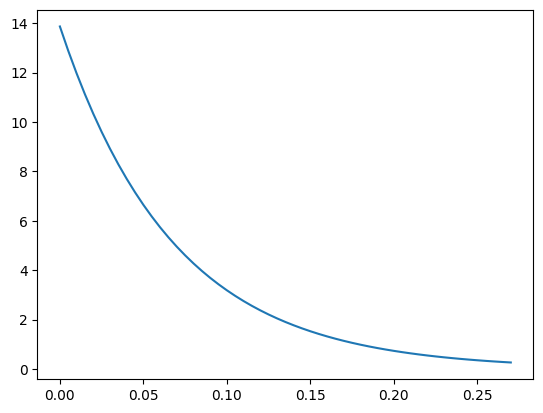

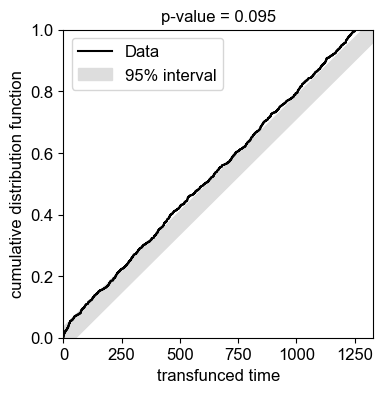

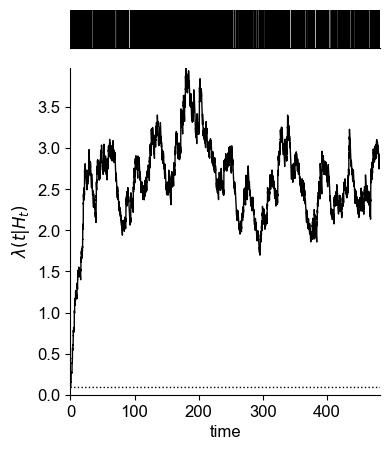

In [12]:
plot_kernel(model1.parameter['alpha'],model1.parameter['beta'])
# Do model assumptions fit test data?
model1.plot_KS()
#Plot intensity of test data
model1.plot_l()

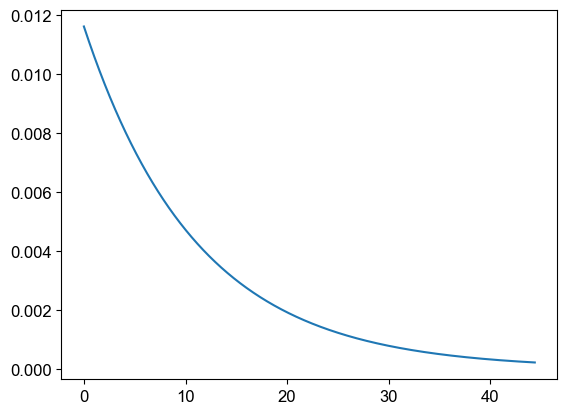

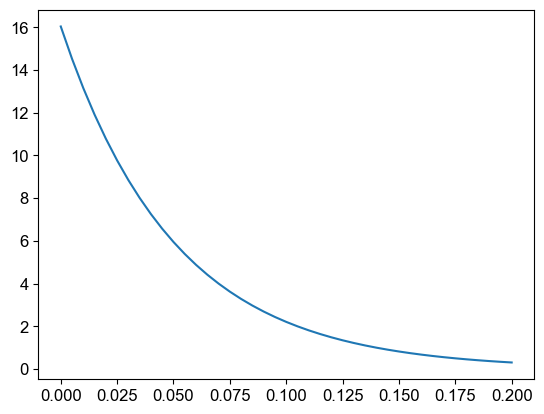

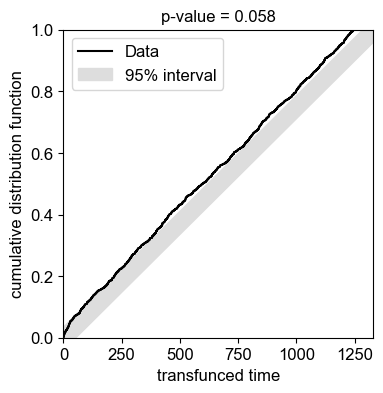

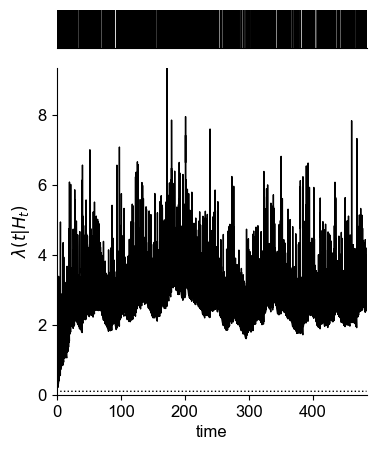

In [14]:
plot_kernel(model2.parameter['alpha'][0],model2.parameter['beta'][0])
plot_kernel(model2.parameter['alpha'][1],model2.parameter['beta'][1])
# Do model assumptions fit test data?
model2.plot_KS()
#Plot intensity of test data
model2.plot_l()

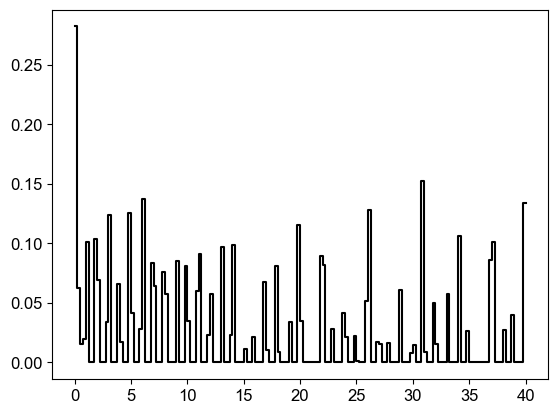

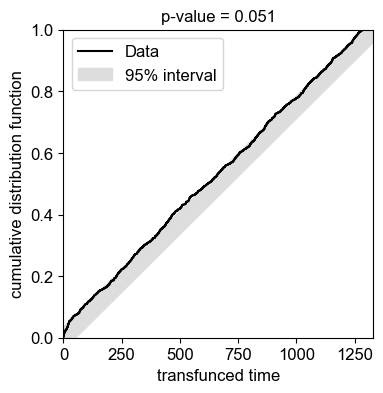

In [15]:
model3.kernel.plot()
# Do model assumptions fit test data?
model3.plot_KS()

# Nerual Temporal Point Process
Du et. al. 2016 proposed a neural model to describe point process data. A RNN is used to extract the sequential information from the point process data. The input ($x_i$) is the log of the interevent times ($\log \tau_i$). The equation governing an RNN is,

\begin{equation}
  h_{i+1} = \sigma(W^h h_i + W^x x_{i+1})
\end{equation}

Here $W^h$ and $W^x$ are weight matrices to be learned. We use the hidden state $h_i$ to model the hazard function $\phi$. We assume exponential decay the of the intensity as time from the last event increases. The following equation expresses this model,

\begin{equation}
  \phi(\tau,h_i) = exp(w^T\tau + v^\phi \cdot h_i + b^\phi )
\end{equation}

$w^T$, $v^{\phi}$, and $b^{\phi}$ are also parameters to learn. Stiching the hazard function together in a piece-wise manner will result in the intensity.

\begin{equation}
  \lambda^* (t) = \phi(t-t_i), \forall t: t_i < t \leq t_{i+1}
\end{equation}

The model is trained by maximum likelihood estimation. The integral of the intensity is not difficult to find in this case because of the simple nature of the hazard function parameterization. If we define $\tau_{n+1}=T-t_n$, then

\begin{equation}
  \int_{t_0}^{T}{\lambda^*(t)dt} = \sum_{i=1}^{n+1}{\frac{1}{w^T}(e^{w^T\tau_i+v^\phi \cdot h_{i-1} + b^\phi}-e^{v^\phi \cdot h_{i-1} + b^\phi})}
\end{equation}


We can also evaluate this model on AIC and log likelihood on test data.

In [16]:
from torch import nn
class NTPP(nn.Module):
    def __init__(self, input_size, hidden_dim, num_rnn=1,T = 500):
        super(NTPP,self).__init__()
        self.hidden_dim = hidden_dim
        self.rnn = nn.RNN(input_size,hidden_dim,num_rnn)
        self.h0 = nn.Parameter(torch.zeros(num_rnn,hidden_dim))
        #self.h0 = torch.zeros(num_rnn,hidden_dim)
        
        self.W = nn.Linear(hidden_dim,1)
        self.w = nn.Parameter(torch.tensor([0.1]))
        #time length of sequence
        self.T = T
        
    def forward(self,x,tau):
        #x is a Nxd tensor representing the input times and marks
        N,d = x.shape
        h,hn = self.rnn(x,self.h0)
        
        o = torch.zeros(N,1).to(device)
        o[0] = self.W(self.h0) + self.w*tau[0]
        for i in range(1,N):
            #hazard(tau) = exp(-exp(w)*tau + W*h + b)
            o[i] = self.W(h[i-1]) + self.w*tau[i]
        return (o,hn)
    
    def loss(self,o,h,tau):
        return -o.sum() + ((torch.exp(o)-torch.exp(o-self.w*tau))/self.w).sum() +\
    (torch.exp(self.W(h)+self.w*(self.T - tau.sum()))-torch.exp(self.W(h)))/self.w

In [27]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
net = NTPP(1,10,num_rnn=1,T=T).to(device)
train_loss = list()
x = torch.log(train_iet).clone().to(device)
train_iet = train_iet.to(device)
print(f"Number of parameters: {sum([p.numel() for p in net.parameters()])}")

Number of parameters: 152


In [28]:
def train(lr,epochs,print_freq = 10):
  optim = torch.optim.Adam(net.parameters(), lr=lr)
  for i in range(epochs):
      o,h = net(x,train_iet)
      loss = net.loss(o,h,train_iet)
      optim.zero_grad()
      loss.backward()
      optim.step()
      train_loss.append(loss.item())
      if (i+1) % print_freq == 0:
          print(f"Loss at epoch {i}: {loss.item()}")#/len(train_iet)
  aic = 2*sum([p.numel() for p in net.parameters()]) + 2*loss.item()
  print(f"AIC: {aic}")
train(5e-3,75)

Loss at epoch 9: 2114.205322265625
Loss at epoch 19: 1789.5191650390625
Loss at epoch 29: 1625.2696533203125
Loss at epoch 39: 1591.1556396484375
Loss at epoch 49: 1582.016845703125
Loss at epoch 59: 1574.948974609375
Loss at epoch 69: 1566.0008544921875
AIC: 3432.829833984375


In [29]:
train(1e-3,50)

Loss at epoch 9: 1560.40185546875
Loss at epoch 19: 1557.3017578125
Loss at epoch 29: 1554.184326171875
Loss at epoch 39: 1550.491943359375
Loss at epoch 49: 1544.8973388671875
AIC: 3393.794677734375


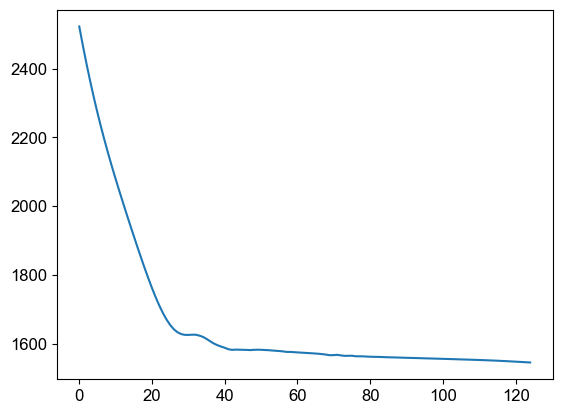

In [30]:
import matplotlib.pyplot as plt
plt.plot(train_loss)

In [31]:
#neg log likelihood on test data
net = net.to(device)
x_ = torch.log(test_iet).clone().to(device)
test_iet = test_iet.to(device)
o,h = net(x_,test_iet)
loss = net.loss(o,h,test_iet)
print(-1*loss.item())#/len(test_iet)

-34.03612518310547


In [32]:
def get_RNN_intensity(net,t,inter_event_times,event_times):
    inten = np.zeros(len(t))
    last_event_ind = 0
    h,hn = net.rnn(np.log(inter_event_times),net.h0)
    h=torch.cat((net.h0,h))
    event_time = torch.cat((torch.tensor([0]),event_times))
    for i in range(len(t)):
        tau = t[i]-event_time[last_event_ind]
        inten[i] = (net.W(h[last_event_ind]) + net.w*tau).detach().item()
        if (last_event_ind+1) < len(event_time) and (i+1)<len(t) and t[i+1] > event_time[last_event_ind+1]:#
            last_event_ind += 1
    return inten

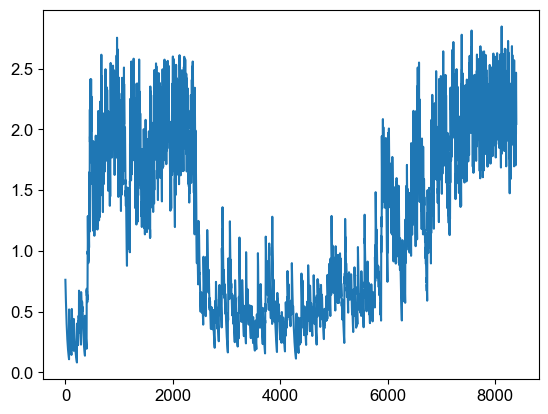

In [33]:
t = np.arange(0.1,T,.25)
net = net.cpu()
inter_event_times = inter_event_times.cpu()

inten = get_RNN_intensity(net,t,inter_event_times,event_times)
plt.plot(np.exp(inten))
plt.show()

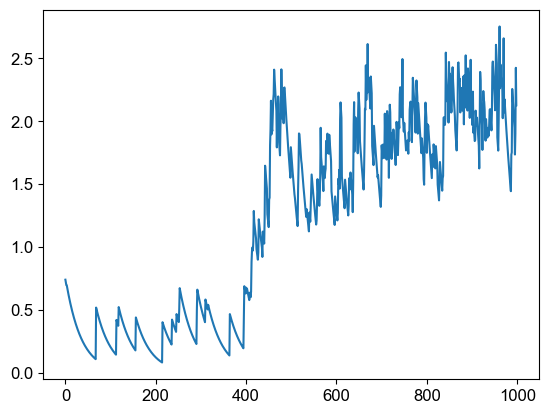

In [34]:
plt.plot(np.exp(inten)[1:1000])
plt.show()

# Fully Neural Network model
Omi et. al. 2020 proposed a fully neural model where the cumulative hazard function($\Phi$) is modeled rather than the hazard function ($\phi$).
\begin{equation}
  \Phi(\tau) = \int_0^\tau{\phi(u)du}
\end{equation}
The log likelihood can still be evaluated, but we must find the derivative of $\Phi$ through auto-differentiation. It is important that $\Phi$ is monotonically increasing with $\tau$ in order to keep $\phi$ from being negative. Therefore, we impose positive weight constraints. Additionally, we use an activation function whose output is always positive because the cumulative hazard function should also be positive. The figure below illustrates this model.

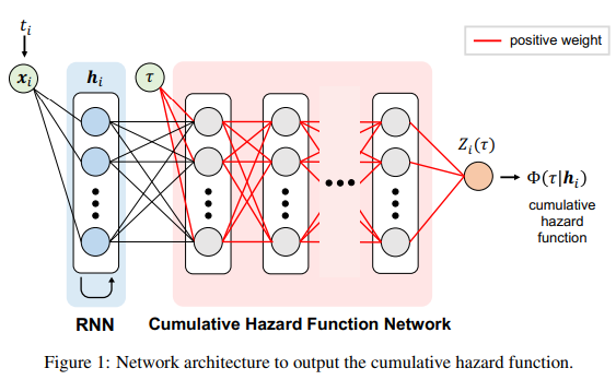

In [43]:
from torch import nn
class NTPP(nn.Module):
    def __init__(self, input_size, hidden_dim, chf_dim=10,num_rnn=1,T = 500):
        super(NTPP,self).__init__()
        self.hidden_dim = hidden_dim
        #self.norm = nn.LayerNorm(input_size)
        self.rnn = nn.RNN(input_size,hidden_dim,num_rnn)
        self.h0 = nn.Parameter(torch.zeros(num_rnn,hidden_dim))
        #self.h0 = torch.zeros(num_rnn,hidden_dim)
        
        self.chf_dim = chf_dim
        self.W = nn.Linear(hidden_dim,chf_dim)
        #w parameter the log(-w). This is for a weight constraint
        self.w = nn.Parameter(torch.rand(chf_dim))
        self.chf = nn.Sequential(nn.Tanh(),nn.Linear(chf_dim,chf_dim),nn.Tanh(), 
                                 nn.Linear(chf_dim,1),nn.Softplus())
        nn.init.uniform_(self.chf[1].weight)
        nn.init.uniform_(self.chf[3].weight)
        #time length of sequence
        self.T = T
        
    def forward(self,x,tau):
        #x is a Nxd tensor representing the input times and marks
        N,d = x.shape
        h,hn = self.rnn(x,self.h0)
        
        o = torch.zeros(N,self.chf_dim).to(device)
        o[0] = self.W(self.h0) + self.w*tau[0]
        for i in range(1,N):
            o[i] = self.W(h[i-1]) + self.w*tau[i]
        self.o = o
        chf = self.chf(self.o)
        return (chf,hn)
    
    def loss(self,chf,h,tau):
        #multiplier of tau
        haz = torch.zeros(len(chf),1)
        for i in range(len(chf)):
            haz[i] = torch.dot(torch.autograd.grad(chf[i], self.o, retain_graph=True)[0][i],self.w)
        L = -torch.log(haz).sum() + chf.sum()
        return L
    
    def get_haz(self,chf):
        haz = torch.zeros(len(chf),1)
        for i in range(len(chf)):
            haz[i] = torch.dot(torch.autograd.grad(chf[i], self.o, retain_graph=True)[0][i],self.w)
        return haz

In [44]:
T = 2100
train_mask = event_times < T
train_iet = inter_event_times[train_mask]
train_et = event_times[train_mask]

test_iet = inter_event_times[torch.logical_not(train_mask)]
test_et = event_times[torch.logical_not(train_mask)] - T


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
net = NTPP(1,5,chf_dim=5,T=T).to(device)
net.h0 = net.h0.to(device)
train_loss = list()
train_iet.requires_grad = True
train_iet = train_iet.to(device)
x = torch.log(train_iet.detach().clone())
x.requires_grad = False

In [45]:
def train(epochs,lr):
  optim = torch.optim.Adam(net.parameters(), lr=lr)
  for i in range(epochs):
      chf,h = net(x,train_iet)
      loss = net.loss(chf,h,train_iet)
      optim.zero_grad()
      loss.backward()
      optim.step()
      train_loss.append(loss.item())
      net.w.data.clamp_(0)
      for name, p in net.chf.named_parameters():
        if 'bias' not in name:
          p.data.clamp_(0)
      if (i+1) % 2 == 0:
          print(f"Loss at epoch {i}/{epochs}: {loss.item()}")#/len(train_iet)
  aic = 2*sum([p.numel() for p in net.parameters()]) + 2*loss.item()
  print(f"AIC: {aic}")
train(15,2e-3)

Loss at epoch 1/15: 3307.24169921875
Loss at epoch 3/15: 3244.073486328125
Loss at epoch 5/15: 3189.799560546875
Loss at epoch 7/15: 3144.004638671875
Loss at epoch 9/15: 3106.138427734375
Loss at epoch 11/15: 3075.87744140625
Loss at epoch 13/15: 3053.216064453125
AIC: 6321.56103515625


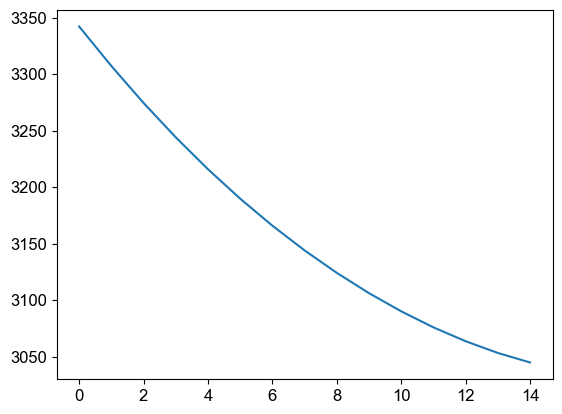

In [46]:
import matplotlib.pyplot as plt
plt.plot(train_loss)

In [47]:
#neg log likelihood on test data
net = net.to(device)
x_ = torch.log(test_iet).clone().to(device)
test_iet = test_iet.to(device)
chf,h = net(x_,test_iet)
loss = net.loss(chf,h,test_iet)
print(-1*loss.item())#/len(test_iet)

-781.5294189453125


# Conclusions
The non-parametric Hawkes process fit the data the best, most likely because the data was in reality discrete. 

Neither neural temporal point process fit well. This is most likely because there was not a significant amount of data available to train. Usually, neural networks require huge amounts of data.